In [5]:
import matplotlib.pyplot as plt
import numpy as np

from physics.sound_propagation import *

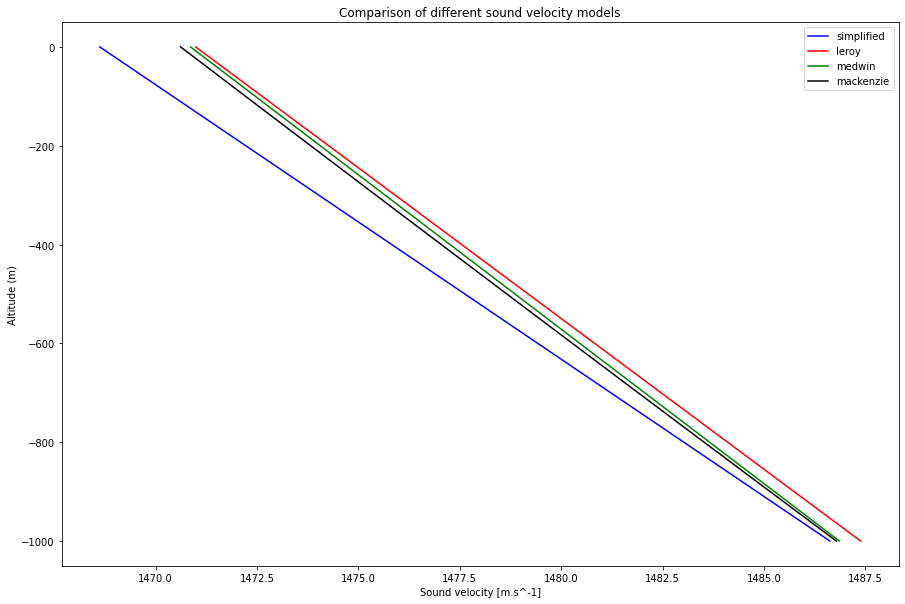

In [6]:
S = np.linspace(0, 42, 100)
T = np.linspace(-2, 40, 100)
z = np.linspace(-1000, 0, 100)

c_simplified = sound_velocity_simplified(35, 5, z)
c_leroy      = sound_velocity_leroy     (35, 5, z)
c_medwin     = sound_velocity_medwin    (35, 5, z)
c_mackenzie  = sound_velocity_mackenzie (35, 5, z)


plt.figure(figsize=(15, 10))

plt.plot(c_simplified, z, c='blue', label='simplified')
plt.plot(c_leroy, z, c='red', label='leroy')
plt.plot(c_medwin, z, c='green', label='medwin')
plt.plot(c_mackenzie, z, c='black', label='mackenzie')

plt.legend()
plt.title('Comparison of different sound velocity models')
plt.xlabel('Sound velocity [m.s^-1]')
plt.ylabel('Altitude (m)')
plt.show()

<ipython-input-31-3bd22fad937a>:32: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(c * sigma)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


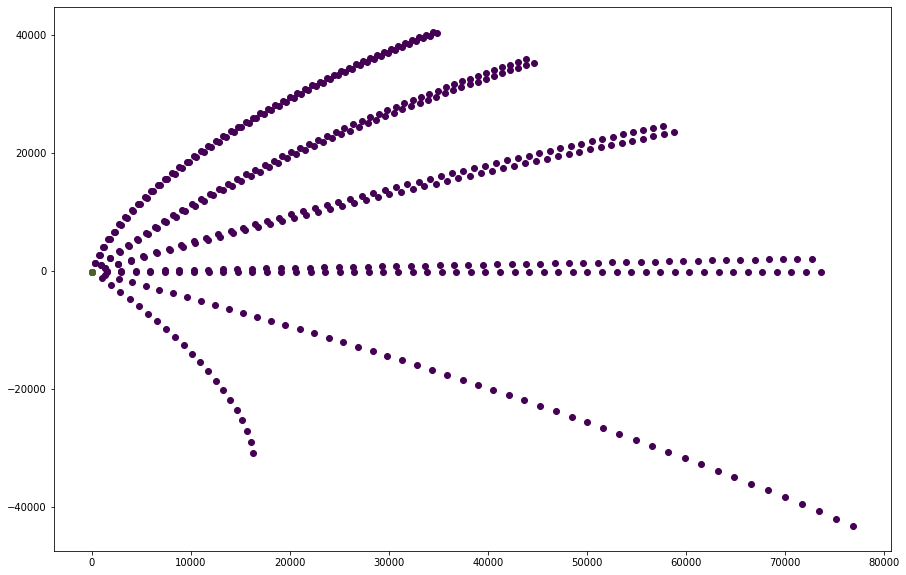

In [31]:
def calc_c (z):
    # wrong because water temperature varies with depth
    return sound_velocity_medwin(35, 5, z)



import random
number_of_colors = 10
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]




# Initial conditions
x0      = 0
z0      = -100
theta_0 = 3  #in radians


def plot_sound_curve(x0, z0, theta_0, c='black'):
    c0      = calc_c(z0)
    sigma = np.sin(theta_0) / c0
    x = x0
    z = z0
    plt.scatter(x, z, c=c)

    dt = 1#0.2
    for t in np.arange(0, 50, dt):

        # Calculate movement direction
        c = calc_c(z)
        theta = np.arcsin(c * sigma)

        # Move
        x += np.cos(theta) * c * dt
        z += np.sin(theta) * c * dt

        plt.scatter(x, z, c=c)




plt.figure(figsize=(15, 10))

for i, theta_0 in enumerate(np.linspace(0, 4, 10)):
    plot_sound_curve(x0, z0, theta_0=theta_0, c=colors[i])
plt.show()

In [4]:
def GROUND_HEIGHT_2D (x: np.ndarray):
    """
    Get ground height in meters
    :param x: position (in meters)
    :return: ground height (in meters)
    """
    return -100. * np.ones(shape=x.shape[0])

[6.38233599]
[20.94867794]
[36.63624684]
[54.49828781]
[76.17212457]
[104.59713328]
[145.93051898]
[216.03302679]
[372.86802316]
[1137.63059425]


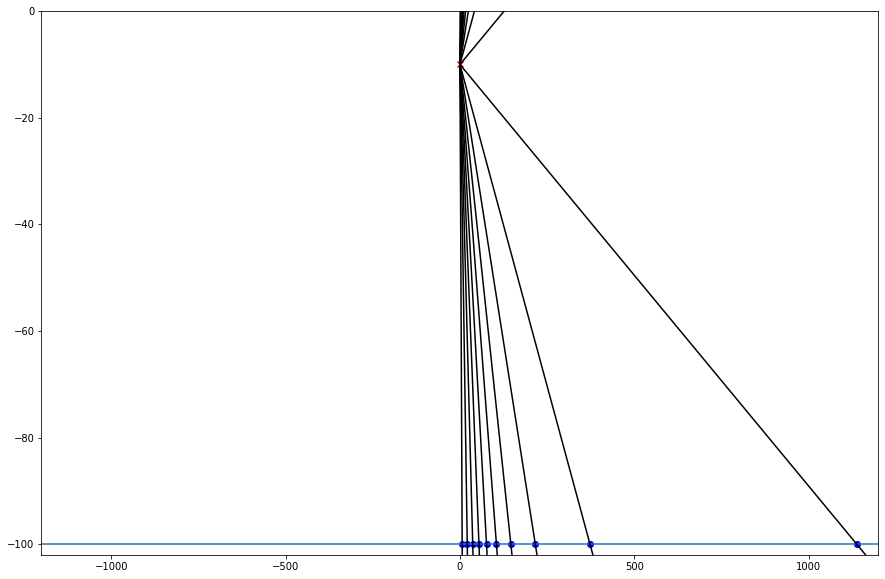

In [20]:
from scipy.optimize import fsolve
from math import pi as PI


plt.figure(figsize=(15, 10))
plt.xlim((-1200, 1200))
plt.ylim((-102, 0))


EMITTER_POS = (0, -10)  # in meters
plt.scatter(*EMITTER_POS, c='red', marker='x')


dist = np.linspace(-1200, 1200, 200)
plt.plot(dist, GROUND_HEIGHT_2D(dist))

angles = np.linspace (-1.5, 1.5, 20)
for angle in angles:
    

    def angle_func (x):
        a = np.tan(angle)
        return a * (x - EMITTER_POS[0]) + EMITTER_POS[1]  # a(x-xE) + yE

    samples = np.linspace(0, 2000, 100)
    plt.plot(samples, angle_func(samples), c='black')
    
    def diff_func (x):
        return np.power(angle_func(x) - GROUND_HEIGHT_2D(x), 2)
    
    x_intersect = fsolve(diff_func, x0=0)
    if x_intersect <= 0: continue
    

    print(x_intersect)
    plt.scatter(x_intersect, GROUND_HEIGHT_2D(x_intersect), c='blue')

plt.show()





